## Классификация MNIST

In [ ]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision.datasets import MNIST

from matplotlib import pyplot as plt
from IPython.display import clear_output

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 502kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.43MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.93MB/s]


Text(0.5, 1.0, 'Image label: 1')

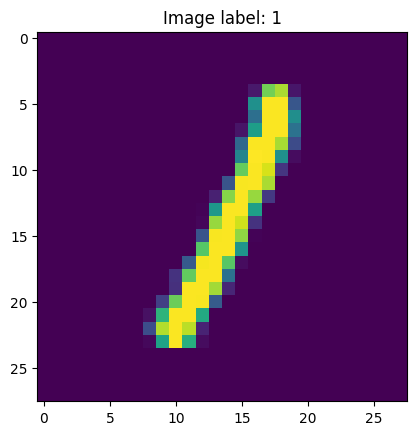

In [ ]:
train_mnist_data = MNIST('.', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_mnist_data = MNIST('.', train=False, transform=torchvision.transforms.ToTensor(), download=True)


train_data_loader = torch.utils.data.DataLoader(
    train_mnist_data,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_mnist_data,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f'Image label: {_label}')

In [ ]:
class ClassMNIST(nn.Module):
  def __init__(self):
    super().__init__()
    self.Linear1 = nn.Linear(28*28, 1024)
    self.Linear2 = nn.Linear(1024, 576)
    self.Linear3 = nn.Linear(576, 128)
    self.Linear4 = nn.Linear(128, 10)


  def forward(self, x):
    x = x.view(x.size(0), -1)  # # преобразуем (B, 1, 28, 28) → (B, 784)
    x = F.relu(self.Linear1(x))
    x = F.relu(self.Linear2(x))
    x = F.relu(self.Linear3(x))
    x = self.Linear4(x)
    return x

In [ ]:
model = ClassMNIST()

In [ ]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 5e-4)

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(iter(train_data_loader)):
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * train_data_loader.batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_data_loader, model, criterion, optimizer)
print("Done!")

Epoch 1
-------------------------------
loss: 2.296500  [   32/60000]
loss: 0.584694  [ 3232/60000]
loss: 0.556654  [ 6432/60000]
loss: 0.105121  [ 9632/60000]
loss: 0.137361  [12832/60000]
loss: 0.121429  [16032/60000]
loss: 0.230022  [19232/60000]
loss: 0.062237  [22432/60000]
loss: 0.078840  [25632/60000]
loss: 0.263498  [28832/60000]
loss: 0.461905  [32032/60000]
loss: 0.032182  [35232/60000]
loss: 0.172071  [38432/60000]
loss: 0.170668  [41632/60000]
loss: 0.115714  [44832/60000]
loss: 0.155364  [48032/60000]
loss: 0.306398  [51232/60000]
loss: 0.098108  [54432/60000]
loss: 0.080009  [57632/60000]
Epoch 2
-------------------------------
loss: 0.026709  [   32/60000]
loss: 0.015591  [ 3232/60000]
loss: 0.103972  [ 6432/60000]
loss: 0.023646  [ 9632/60000]
loss: 0.068516  [12832/60000]
loss: 0.119807  [16032/60000]
loss: 0.169045  [19232/60000]
loss: 0.065234  [22432/60000]
loss: 0.013390  [25632/60000]
loss: 0.397437  [28832/60000]
loss: 0.009508  [32032/60000]
loss: 0.173303  [352

Оценим качество классификации:

In [ ]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in train_data_loader:
        y_predicted = model(batch[0].reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
train_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [ ]:
print(f'Neural network accuracy on train set: {train_acc:3.5}')

Neural network accuracy on train set: 0.99217


 0.99042

In [ ]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in test_data_loader:
        y_predicted = model(batch[0].reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
test_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [ ]:
print(f'Neural network accuracy on test set: {test_acc:3.5}')

Neural network accuracy on test set: 0.9797
